# Pengenalan Sidik Jari Menggunakan CNN

Kelompok 8

1. Yohanes Gilang Prasaja Putra	(20507334015)

2. Rizki Prayoga Sutrisna		(20507334038)

3. Muhamad Bambang Irawan	    (20507334041)

4. Erlangga Bayu Setiawan	    (20507334048)

In [1]:
# Import library

import numpy as np
import matplotlib.pyplot as plt
import keras
import random
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

(6000, 90, 90, 1) (6000, 4)


C:\Users\hp\miniconda3\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


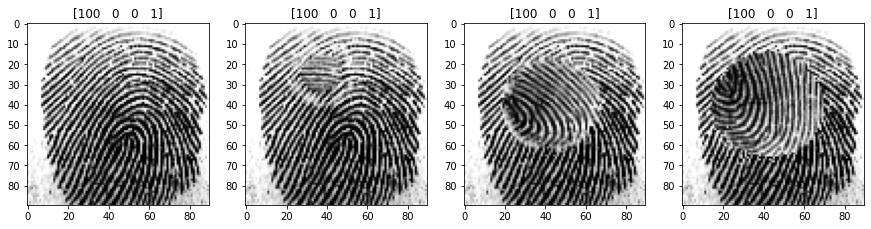

In [2]:
# Load datasets

# Memasukka datasets dari device komputer. Data yang dimasukkan berupa .npz dan .npy yaitu standart format untuk Multiple Numpy Array, untuk .npy: File NPY menyimpan semua informasi yang diperlukan untuk merekonstruksi array di komputer mana pun, yang mencakup informasi dtype dan shape.
# Dengan menggunakan .npy .npz: membaca dari disk akan sangat cepat, ukuran penyimpanan lebih kecil

x_real = np.load('dataset/x_real.npz')['data'] # 'data' untuk membuat data berisi image. Real untuk datasheets asli atau yang paling baik
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data'] # Easy untuk data dari user yang paling bagus kualitasnya
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data'] # Medium untuk data dari user yang sedikt kurang kualitasnya
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data'] # Hard untuk data dari user yang paling sulit untuk dikenali karena banyak noisenya
y_hard = np.load('dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

Dari 'print(x_real.shape, y_real.shape)' dihasilkan 
- x_real.shape: (6000, 90, 90, 1) --> ukuran img
- y_real.shape: (6000, 4) 

Untuk 4 gambar di atas yaitu salah satu image dari data yang diinputkan. Urutan data dari kiri ke kanan yaitu x_real, x_easy, x_medium, dan x_hard. Terlihat jika gambar sidik jari x_rela paling bagus dan x_hard paling banyak noisenya.

[100 0 0 1]
- 100 --> subject ID
- 0   --> gender (male 0, female 1)
- 0   --> left_or_right_hand (left 0, right 1)
- 1   --> finger index (0-4)

In [3]:
# Train test split

x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


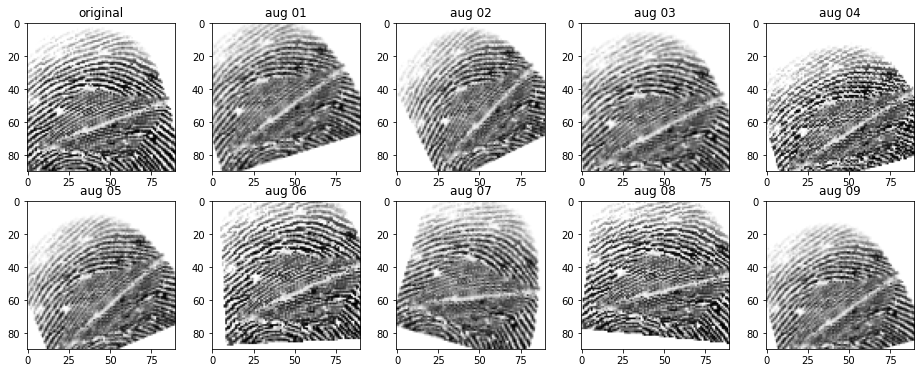

In [4]:
# Preview augmentasi: Proses pengumpulan data

augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

Augmentasi data adalah strategi yang memungkinkan praktisi meningkatkan keragaman data yang tersedia untuk model pelatihan secara signifikan , tanpa benar-benar mengumpulkan data baru. Teknik augmentasi data seperti cropping, padding, dan horizontal flipping biasanya digunakan untuk melatih jaringan neural yang besar.

Gambar di atas merupakan hasil dari proses augmentasi. Terdapat 9 langkah/proses yang dilakukan.

In [5]:
# Make label dictionary lookup table

label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

Tabel pencarian dari y_real (label) untuk mencari data dari datasets 

In [6]:
# Data generator

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

Data generator: mengambil jalur ke direktori yang berisi gambar yang diurutkan dalam sub direktori dan parameter augmentasi gambar.

In [7]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

Mengacak array

In [8]:
# Create model

x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs) # 32 filter atau konvolusi ukuran 3 X 3, dengan relu sebagai fungsi aktivasi.
feature = layers.MaxPooling2D(pool_size=2)(feature) # mengurangi dimensi spasial dari volume keluaran

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature) # 32 filter atau konvolusi ukuran 3 X 3, dengan relu sebagai fungsi aktivasi.
feature = layers.MaxPooling2D(pool_size=2)(feature) # mengurangi dimensi spasial dari volume keluaran

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net]) # Lapisan yang mengurangi dua masukan

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net) # Meratakan masukan. Tidak mempengaruhi ukuran batch
net = layers.Dense(64, activation='relu')(net) # Mengklasifikasikan citra berdasarkan output dari convolutional layer
net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 22, 22, 32)   9568        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 22, 22, 32)   0           ['model[0][0]',            

In [9]:
# Train data

history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
1385/1385 [==============================] - 278s 200ms/step - loss: 0.2374 - acc: 0.8983 - val_loss: 0.0574 - val_acc: 0.9749
Epoch 2/15
1385/1385 [==============================] - 292s 211ms/step - loss: 0.1337 - acc: 0.9481 - val_loss: 0.0362 - val_acc: 0.9839
Epoch 3/15
1385/1385 [==============================] - 262s 189ms/step - loss: 0.1060 - acc: 0.9595 - val_loss: 0.0209 - val_acc: 0.9898
Epoch 4/15
1385/1385 [==============================] - 268s 194ms/step - loss: 0.0883 - acc: 0.9666 - val_loss: 0.0084 - val_acc: 0.9973
Epoch 5/15
1385/1385 [==============================] - 280s 202ms/step - loss: 0.0785 - acc: 0.9712 - val_loss: 0.0210 - val_acc: 0.9922
Epoch 6/15
1385/1385 [==============================] - 287s 207ms/step - loss: 0.0703 - acc: 0.9735 - val_loss: 0.0396 - val_acc: 0.9853
Epoch 7/15
1385/1385 [==============================] - 288s 208ms/step - loss: 0.0676 - acc: 0.9759 - val_loss: 0.0112 - val_acc: 0.9953
Epoch 8/15
1385/1385 [============

Dari proses training data di atas di dapat akurasi pembacaan sidik jari hingga 99%

1/1 [==============================] - 0s 24ms/step
Infomation confirm! Fingerprint matches: accuration [[99.61862]] %


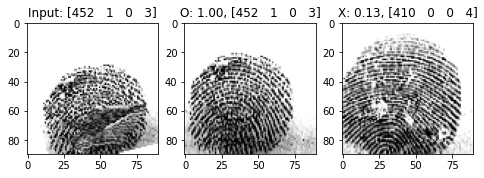

In [51]:
# Evaluation

# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

if rx.all()==random_img.all():
    print("Infomation confirm! Fingerprint matches: accuration",pred_rx*100, "%")
else:
    print("Prediction is wrong!")

Pengambilan data user secara acak dari datasets yang dimasukkan. Ditampilkan output berupa gambar kiri input user, tengah hasil yang sesuai, kanan hasil yang tidak sesuai.

Menerapkan beberapa augmentasi (gaussian blur, zoom, translation, rotation) ke input random image.
Gambar tengah adalah jawabannya sehingga memiliki akurasi hingga 99%, sebaliknya gambar kanan salah sehingga memiliki akurasi 0%. 

Berdasarkan salah satu hasil di atas, gambar kiri sama dengan gambar tengah sehingga hasil match (cocok/sama) dengan code [425 1 0 3] dan akurasi 99.61862%